# IMPORT THE NECESSARY LIBRARIES
At this stage, import important libraries. for model development purposes.

In [1]:
import wandb
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import dill
import re

from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# SETUP CONSTANTS
In this block, we define various constants used in the model training and evaluation process. These constants include paths (directory locations) for datasets, model objects, training reports, as well as important hyperparameters such as batch size, number of epochs, image size, and optimization parameters.

## function

In [2]:
def load_object(file_path):
    """
    Function to load an object from a file using the `dill` module.
    Args:
        file_path (str): The file location of the object to be loaded.
    Returns:
        object: The object loaded from the file.
    """

    try:
        with open(file_path, 'rb') as file_obj:
            return dill.load(file_obj)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

## main program

In [ ]:
# ==========================================================================================
# ==================================== PARENT PATH CONSTANT ================================
# ==========================================================================================
PARENT_DATASET_PATH = ".."
ARTIFACTS_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts")
DATA_INGESTION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_ingestion")
DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_transformation")
OBJECT_PATH = os.path.join(ARTIFACTS_PATH, "objects")
REPORT_PATH = os.path.join(ARTIFACTS_PATH, "reports")
MODEL_PATH = os.path.join(ARTIFACTS_PATH, "models")



# ==========================================================================================
# ==================================== DATA PATH CONSTANT ==================================
# ==========================================================================================
TRAIN_PATH = os.path.join(DATA_INGESTION_ARTIFACTS_DIR_PATH, "dataset-resized")
TRAIN_TFRECOARD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "train_trashnet.tfrecord")
VALID_TFRECORD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "valid_trashnet.tfrecord")



# ==========================================================================================
# ==================================== REPORTS PATH CONSTANT ===============================
# ==========================================================================================
MODEL_NAME = "DenseNet121"
TARGET_KERAS_MODEL_PATH = os.path.join(MODEL_PATH, f"{MODEL_NAME}_model.keras")
TABEL_TRAINING_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "tabel_pelatihan.csv")
TABEL_EPOCH_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "tabel_epoch.csv")
PLOT_TRAINING_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "plot_pelatihan.png")
PLOT_CONFUSION_MATRIX_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "plot_confusion_matrix.png")
CLASSIFICATION_REPORT_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "classification_report.txt")



# ==========================================================================================
# =============================== OBJECT PATH CONSTANT  ====================================
# ==========================================================================================
LABEL_LIST_PATH = os.path.join(OBJECT_PATH, "label_list.pkl")
CLASS_WEIGHTS_PATH = os.path.join(OBJECT_PATH, "class_weights.pkl")
LABEL_LIST = load_object(LABEL_LIST_PATH)
CLASS_WEIGHTS = load_object(CLASS_WEIGHTS_PATH)
IMAGE_SIZE = (224, 224)

# TRAINING WORKFLOW

## Step 1. Build Architecture Model


### function

In [4]:
base_model = tf.keras.applications.DenseNet121 (
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3) 
)
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In this step, we will build a deep learning model architecture using **DenseNet121** as the base model (pretrained). This base model is pretrained on the ImageNet dataset and will be used as the feature extractor for our dataset.
- **Base Model (DenseNet121)**: This model architecture is used as a base because it has been trained on a large dataset (ImageNet), so it can recognize common visual feature patterns in images. We do not use the output layer of this pretrained model (`include_top=False`) in order to customize it to our own dataset.
- **Global Average Pooling**: After passing the base model, we add a pooling layer to reduce the dimensionality of the output of the base model. This pooling takes the average of all the features to produce one vector per channel, so that it can be more easily processed in the next fully connected layer.
- **Output Layer**: Finally, we add an output layer with sigmoid activation. In case of binary classification, this layer produces 1 output node, while in case of multi-class classification, this layer produces as many outputs as the number of classes.
-  Trainability**: The pretrained part of the model can be selected whether to be trained or not by setting `base_model_trainable`.
The `build_model` function is used to build and compile the model with loss, metrics, optimizer defined.

In [5]:
def build_model(
      input_shape=None,
      num_classes=None,
      pretrained_model=None,
    ):
    # Input layer
    input_layer = tf.keras.Input(shape=input_shape)

    # Base model pretrained
    pretrained_model.trainable = False

    # Input melewati base model
    x = pretrained_model(input_layer, training=False)

    # Global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    output_num = 1 if len(num_classes) == 2 else len(num_classes)
    activation = 'sigmoid' if output_num == 1 else 'softmax'
    output_layer = tf.keras.layers.Dense(output_num, activation=activation)(x)

    # Membuat model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

Give `wandb.init` your config

In [6]:
run = wandb.init(
    project='trashnet-adatama-test',
    config={
        "learning_rate": 0.001,
        "loss_function": "sparse_categorical_crossentropy",
        "metrics": ['accuracy'],
        "batch_size": 32,
        "epochs": 150,
        "architecture": "DenseNet121",
        "dataset": "TrashNet",
    }
)

config = wandb.config


model = build_model(
    input_shape=(*IMAGE_SIZE, 3),
    num_classes=LABEL_LIST,
    pretrained_model=base_model,
  )


optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(
    optimizer=optimizer,
    loss=config.loss_function,
    metrics=config.metrics
)


model.summary()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kanshinbatosai (kanshinbatosai-universitas-diponegoro). Use `wandb login --relogin` to force relogin


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## Step 2. Load, Batching, Prefetch and Caching Dataset

In this step, we apply three main techniques to improve data processing performance: batching, prefetching and caching.

- **Load**: Load the tensroflow dataset, for model training.
- **Batching**: Divide the data into small groups (batches) of a certain size (e.g. `BATCH_SIZE`). This is intended to make the data more efficient during model training.
- **Prefetching**: Fetch the next batch of the dataset before the current batch is finished processing. This will help in reducing the waiting time during the model training process.
- **Caching**: The dataset is stored in memory (cached) after batch and prefetch are applied. This reduces the time to read the dataset from disk and speeds up the data access process for the next batch.

### function

In [7]:
def custom_title_print(title, n_strip=80):
    """
    Prints a custom title with a surrounding strip of '=' characters.

    Args:
        title (str): The title to print.
        n_strip (int, optional): Number of '=' characters used to format the title. Default is 80.
    """
    print('=' * n_strip)
    print(f' {title.upper()} '.center(n_strip, '='))
    print('=' * n_strip)

In [8]:
def show_data_info(**datasets):
    """
    Displays detailed information about a given dataset.

    Args:
    **datasets: One or more datasets to display information about.
    """

    try:
        for dataset_name, dataset in datasets.items():
            custom_title_print(f"{dataset_name} info")
            print(f'info {dataset_name}: {dataset}')
            print(f'number of {dataset_name}: {len(dataset)}')
            print()
    except Exception as e:
        print(f'''
            explicitly input parameter names such as:
            show_data_info(train_dataset=train_ds, valid_dataset=valid_ds)
        ''')

In [9]:
class DataInspector:
    """
    The `DataInspector` class is responsible for inspecting and visualizing
    the images in the training, validation, and testing datasets.
    """

    def __init__(self, label_encoding, figsize):
        """
        Initialize the `DataInspector` class.

        Args:
        label_encoding (dict): Mapping from numeric labels to class labels.
        figsize (tuple): Size of the figure for the image visualization plot.
        """
        self.label_encoding = label_encoding
        self.figsize = figsize

    def _custom_title_print(self, title, n_strip=80):
        """
        Displays a specially formatted title with separators.

        Args:
        title (str): The title to display.
        n_strip (int, optional): The number of characters for the separator line. Default is 80.
        """
        print('=' * n_strip)
        print(f' {title.upper()} '.center(n_strip, '='))
        print('=' * n_strip)

    def _inspect_single_dataset(self, dataset, ds_name, ispath, idx):
        """
        Helper function to inspect a specific dataset.

        Args:
        dataset (tf.data.Dataset): The dataset to inspect.
        ds_name (str): The name of the dataset (train, valid, test).
        idx (int, optional): The index to start sampling images. Default 1.
        """

        plt.figure(figsize=self.figsize)

        if ispath:
            for i, (image, label, path) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label, path)
                self._plot_images(ds_name, image, label)
        else:
            for i, (image, label) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label)
                self._plot_images(ds_name, image, label)
        plt.show()

    def _print_data_info(self, title, image, label, image_path=None):
        """
        Displays detailed information about the image and labels.

        Args:
        title (str): Title of the information to be displayed.
        image (tf.Tensor): The inspected image.
        label (int): The label of the inspected image.
        image_path (str, optional): The path of the image file (if any). Default is None.
        """
        print('\n\n')
        self._custom_title_print(title)

        if image_path is not None:
            print(f'image path: {image_path}')

        print(f'shape-image: {image.shape}')
        print(f'dtype-image: {image.dtype}')
        print(f'max-intensity: {tf.reduce_max(image)}')
        print(f'min-intensity: {tf.reduce_min(image)}')

        print(f'label: {label} -> {self.label_encoding[label.numpy()]}')
        print(f'label-shape: {label.shape}')
        print(f'label-type: {label.dtype}')
        print()

    def _plot_images(self, ds_name, image, label):
        """
        Dynamically visualize images from training, validation, and testing datasets.

        Args:
        datasets (dict): The datasets to plot (train_image, valid_image, test_image).
        """
        plt.title(f'{ds_name.capitalize()} Label: {self.label_encoding[label.numpy()]}')
        plt.imshow(image.numpy(), cmap='gray')
        plt.axis("off")

    def inspect(self, ispath=False, idx=1, **datasets):
        """
        Inspect images from the training, validation, or test datasets (or a combination).

        Args:
        datasets (dict): The datasets to inspect (train_ds, valid_ds, test_ds).
        You can enter one or more.
        """
        for ds_name, ds in datasets.items():
            self._inspect_single_dataset(ds, ds_name, ispath, idx)

In [10]:
def display_info_dataset_batched(batch_size, dataset, dataset_batched, kind):
    custom_title_print(f' {kind} ')
    print(f"Info data: {dataset_batched}")
    print(f"Number of data: {len(dataset)}")
    if not re.search('test', kind.lower(), re.IGNORECASE):
        print(f"AFTER BATCH: {batch_size}")
        print(f"Number of data: {len(dataset_batched)}")

## main program

### load data

In [11]:
train_tf_dataset_loaded = tf.data.Dataset.load(TRAIN_TFRECOARD_PATH, compression="GZIP")
valid_tf_dataset_loaded = tf.data.Dataset.load(VALID_TFRECORD_PATH, compression="GZIP")

In [12]:
show_data_info(
    train=train_tf_dataset_loaded,
    valid=valid_tf_dataset_loaded
)

================================== TRAIN INFO ==================================
info train: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train: 2274

================================== VALID INFO ==================================
info valid: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid: 253



In [13]:
inspector = DataInspector(
    LABEL_LIST,
    figsize=(12,6)
)




=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.9551031589508057
min-intensity: 0.07845127582550049
label: 3 -> paper
label-shape: ()
label-type: <dtype: 'int32'>



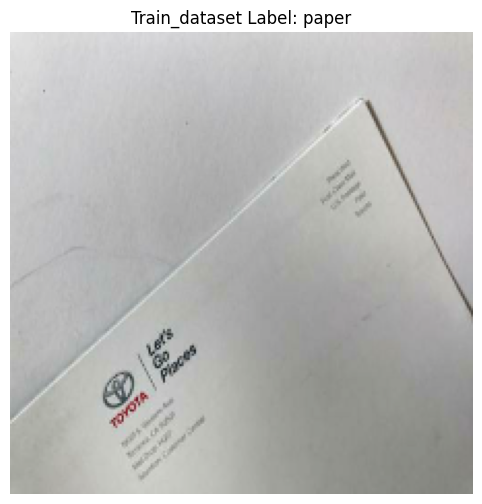




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 1.0
min-intensity: 0.02889055386185646
label: 2 -> metal
label-shape: ()
label-type: <dtype: 'int32'>



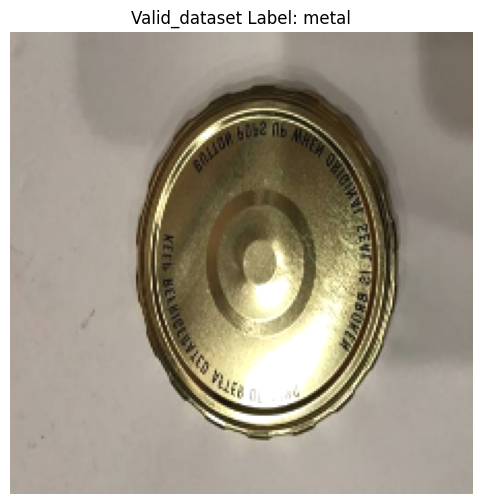

In [14]:
inspector.inspect(
    train_dataset=train_tf_dataset_loaded,
    valid_dataset=valid_tf_dataset_loaded,
    idx=10
)

We batch the training and validation datasets, then prefetch and cach to make the training performance more efficient. The test dataset only uses prefetching and caching, without batching, because generally no batch is needed for test data.

In [15]:
train_tf_images_batched = train_tf_dataset_loaded.batch(config.batch_size).prefetch(tf.data.AUTOTUNE).cache()
valid_tf_images_batched = valid_tf_dataset_loaded.batch(config.batch_size).prefetch(tf.data.AUTOTUNE).cache()

In [16]:
display_info_dataset_batched(config.batch_size, train_tf_dataset_loaded, train_tf_images_batched, kind='train dataset')
display_info_dataset_batched(config.batch_size, valid_tf_dataset_loaded, valid_tf_images_batched, kind='valid dataset')

===============================  TRAIN DATASET  ================================
Info data: <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Number of data: 2274
AFTER BATCH: 32
Number of data: 72
===============================  VALID DATASET  ================================
Info data: <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Number of data: 253
AFTER BATCH: 32
Number of data: 8


## Step 3. Training Model

### function

In [17]:
class TrainingLogger(tf.keras.callbacks.Callback):
    """
    Callback to log training results at each epoch to a CSV file.

    Args:
    log_file (str): Path to the CSV log file.
    batch_size (int): Batch size used in training.
    """
    def __init__(self, log_file, batch_size):
        super(TrainingLogger, self).__init__()
        self.log_file = log_file
        self.batch_size = batch_size

        if not os.path.exists(log_file):
            os.makedirs(os.path.dirname(self.log_file), exist_ok=True)
            with open(log_file, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Epoch", "Batch Size", "val_acc (%)", "val_loss (%)"])

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback called at the end of each epoch to log
        val_loss and val_accuracy to a CSV file.

        Args:
        epoch (int): Index of the current epoch.
        logs (dict): Dictionary that stores training metrics such as val_loss and val_accuracy.
        """
        val_loss = logs.get('val_loss', 0) * 100  
        val_acc = logs.get('val_accuracy', 0) * 100 


        with open(self.log_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, self.batch_size, round(val_acc, 4), round(val_loss, 4)])


class WandbImageLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, label_list, sample_count=5):
        super().__init__()
        self.validation_data = validation_data
        self.label_list = label_list
        self.sample_count = sample_count

    def on_epoch_end(self, epoch, logs=None):
        images, labels = next(iter(self.validation_data))

        sample_images = images[:self.sample_count]
        sample_labels = labels[:self.sample_count]
        predictions = self.model.predict(sample_images)

        wandb_images = []
        for i in range(self.sample_count):
            true_label = self.label_list[sample_labels[i].numpy()]
            predicted_label = self.label_list[np.argmax(predictions[i])]

            plt.figure()
            plt.imshow(sample_images[i])
            plt.title(f"True: {true_label}, Pred: {predicted_label}")

            wandb_images.append(wandb.Image(plt, caption=f"True: {true_label}, Pred: {predicted_label}"))
            plt.close()

        wandb.log({"predictions": wandb_images}, step=epoch)

### main program

#### setup callbacks

This step defines some callbacks that are useful during the model training process, and trains the model with the specified callbacks. These callbacks help monitor metrics and save the model results during training.

- **TrainingLogger**: This callback is responsible for logging the training results such as `val_accuracy` and `val_loss` after each epoch into a CSV file. This helps in monitoring the model performance at each epoch without having to look at the terminal output directly.
- **ModelCheckpoint**: This callback saves the model every time there is an increase in performance based on the `val_loss` value. The best model will be saved in the location specified in the `TARGET_KERAS_MODEL_PATH` file.
- **ReduceLROnPlateau**: This callback will automatically reduce the learning rate if the model does not show any improvement after a certain number of epochs, based on the `patience` parameter. This helps the model not to get stuck in local minima and can achieve better performance.

- **EarlyStopping**: This callback automatically stops training if the model does not show improvement after a certain number of epochs, with the parameter `patience`. This is to avoid overfitting.

Once all callbacks are defined, the model is trained using the batched dataset, validated, and monitored by this callback.

In [18]:
training_logger = TrainingLogger(
    log_file=TABEL_TRAINING_PATH, 
    batch_size=config.batch_size 
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=TARGET_KERAS_MODEL_PATH,  
    monitor='val_loss',  
    save_best_only=True,  
    save_weights_only=False, 
    mode='min',
    verbose=1
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.5,
  patience=10,
  verbose=1,
  mode='auto',
  min_delta=0.001,
  cooldown=0,
  min_lr=0 
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', 
  patience=25, 
  restore_best_weights=True,
  verbose=1 
)

wandb_logger = WandbImageLogger(
    validation_data=valid_tf_images_batched, 
    label_list=LABEL_LIST,
    sample_count=10
)

#### training stage

In [ ]:
history = model.fit(
    train_tf_images_batched, 
    validation_data=valid_tf_images_batched, 
    epochs=config.epochs,
    class_weight=CLASS_WEIGHTS,
    callbacks=[
        training_logger,
        checkpoint_callback, 
        plateau_callback,
        early_stopping,
        wandb_logger,
        WandbMetricsLogger(),
  ]
)

wandb.finish()

Epoch 1/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3527 - loss: 1.7035
Epoch 1: val_loss improved from inf to 0.89512, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/objects/DenseNet121_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 91s 848ms/step - accuracy: 0.3542 - loss: 1.6994 - val_accuracy: 0.6838 - val_loss: 0.8951 - learning_rate: 0.0010
Epoch 2/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6586 - loss: 0.9057
Epoch 2: val_loss improved from 0.89512 to 0.69753, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/objects/DenseNet121_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6592 - loss: 0.9047 - val_accuracy: 0.7787 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 3/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7568 - loss: 0.7101
Epoch 3: val_loss i

epoch/accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch/learning_rate,███████████████████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▂▁▂▃▄▄▅▅▆▆▆▅▆▆▆▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████████
epoch/val_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.9934
epoch/epoch,100
epoch/learning_rate,6e-05
epoch/loss,0.06065
epoch/val_accuracy,0.92095


# MODEL EVALUATION

## function

In [ ]:
def plot_training_history(history, save_path):
    """
    Plot training and validation accuracy and loss curves.

    Args:
    - history: History object yang dikembalikan oleh model.fit()
    - save_path (str): Path di mana gambar kurva akan disimpan.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    dir_path = os.path.dirname(save_path)
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(save_path)

    plt.show()

In [ ]:
def evaluate_model(
      model,
      tf_dataset,
      class_names,
      confusion_plot_path=None,
      classification_report_path=None,
      save_plot=True,
      save_report=True,
      normalize=False, 
      figsize=(6,4)
    ):
    """
    Evaluate the model and generate confusion matrix and classification report for binary or multiclass classification.

    Args:
    - model: The trained model.
    - tf_dataset: The dataset for evaluation.
    - class_names: List of available class names.
    - confusion_plot_path: Path to save confusion matrix plot.
    - classification_report_path: Path to save classification report.
    - save_plot: Save confusion matrix plot if True.
    - save_report: Save classification report if True.
    - normalize: If True, the confusion matrix will be normalized (scale 0.0 - 1.0).
    """

    y_true = []
    y_pred = []

    for images, labels in tqdm(tf_dataset, desc='Evaluation'):
        predictions = model.predict(images, verbose=0)

        y_true.extend(tf.squeeze(labels).numpy())

        if predictions.shape[1] == 1:
            y_pred.extend((predictions > 0.5).astype(int))
        else:
            y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f" 
    else:
        fmt = "d" 
    title = 'Confusion Matrix (Jumlah)'

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    if save_plot:
        plot_path = confusion_plot_path
        plot_dir_path = os.path.dirname(plot_path)
        os.makedirs(plot_dir_path, exist_ok=True)
        plt.savefig(plot_path)
        print(f"Confusion matrix plot saved to {plot_path}")

    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    if save_report:
        classification_report_dir_path = os.path.dirname(classification_report_path)
        os.makedirs(classification_report_dir_path, exist_ok=True)
        with open(classification_report_path, 'w') as f:
            f.write(report)
        print(f"Classification report saved to {classification_report_path}")

## main program

In [ ]:
evaluation = model.evaluate(valid_tf_images_batched)
print(f'Model evaluation on validation data: {evaluation}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9099 - loss: 0.2970
Model evaluation on validation data: [0.2792067527770996, 0.9051383137702942]


### save tabel epochs

In [ ]:
history_df = pd.DataFrame(history.history).reset_index()
history_df.rename(columns={'index': 'epoch'}, inplace=True)
history_df['epoch'] = history_df['epoch'] + 1
history_df = history_df.round({
    'accuracy': 4,
    'loss': 4,
    'val_accuracy': 4,
    'val_loss': 4,
    'learning_rate': 10
  }
)

history_df

,epoch,accuracy,loss,val_accuracy,val_loss,learning_rate
0,1,0.4617,1.4054,0.6838,0.8951,0.001000
1,2,0.6785,0.8705,0.7787,0.6975,0.001000
2,3,0.7555,0.7045,0.8142,0.6099,0.001000
3,4,0.7924,0.6106,0.8300,0.5544,0.001000
4,5,0.8153,0.5461,0.8182,0.5149,0.001000
...,...,...,...,...,...,...
96,97,0.9930,0.0618,0.9209,0.2848,0.000125
97,98,0.9930,0.0616,0.9209,0.2848,0.000125
98,99,0.9930,0.0614,0.9209,0.2847,0.000125
99,100,0.9934,0.0608,0.9209,0.2840,0.000063


In [ ]:
tabel_epoch_dir_path = os.path.dirname(TABEL_EPOCH_PATH)
os.makedirs(tabel_epoch_dir_path, exist_ok=True)
history_df.to_csv(TABEL_EPOCH_PATH, index=False)

### save plot training model

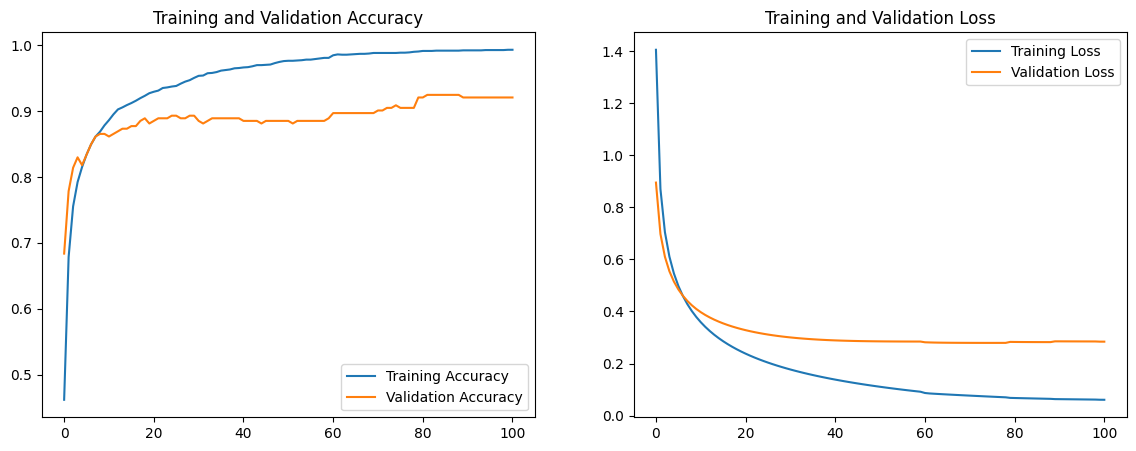

In [ ]:
plot_training_history(history, PLOT_TRAINING_PATH)

### save confusion matriks dan classification report

In [ ]:
best_model = tf.keras.models.load_model(TARGET_KERAS_MODEL_PATH)

Evaluation: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Confusion matrix plot saved to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/reports/DenseNet121/plot_confusion_matrix.png


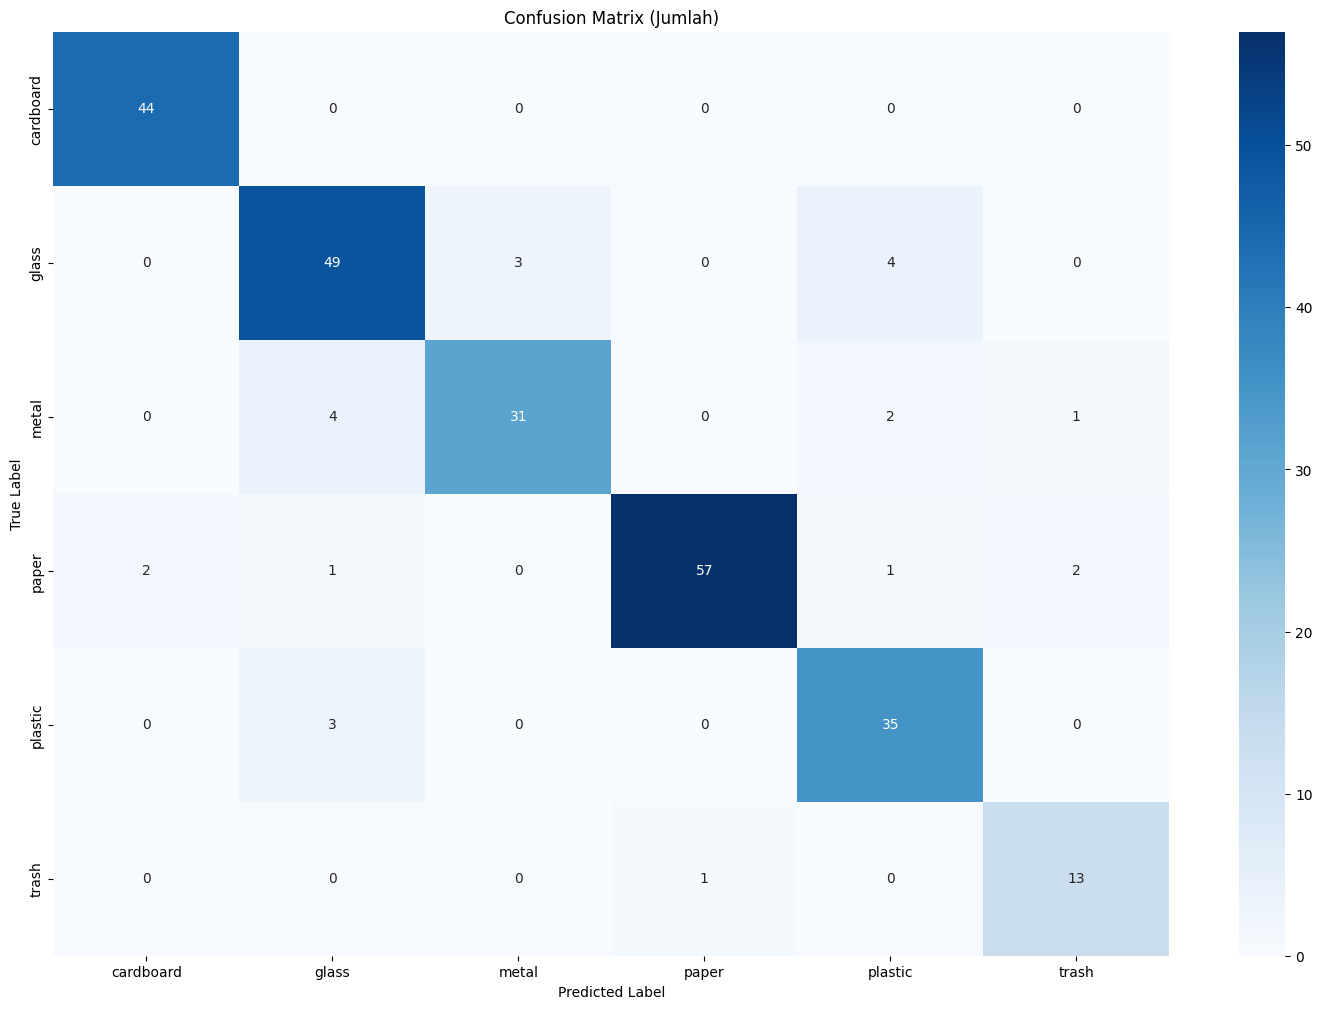

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      1.00      0.98        44
       glass       0.86      0.88      0.87        56
       metal       0.91      0.82      0.86        38
       paper       0.98      0.90      0.94        63
     plastic       0.83      0.92      0.88        38
       trash       0.81      0.93      0.87        14

    accuracy                           0.91       253
   macro avg       0.89      0.91      0.90       253
weighted avg       0.91      0.91      0.91       253

Classification report saved to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/reports/DenseNet121/classification_report.txt


In [ ]:
evaluate_model(
    best_model,
    valid_tf_images_batched,
    LABEL_LIST,
    confusion_plot_path=PLOT_CONFUSION_MATRIX_PATH,
    classification_report_path=CLASSIFICATION_REPORT_PATH,
    save_plot=True,
    save_report=True,
    normalize=False,
    figsize=(18, 12)
)

### Hyperparameter Tuning

In [ ]:
def build_model(input_shape, num_classes, pretrained_model):
    # Input layer
    input_layer = tf.keras.Input(shape=input_shape)

    # Freeze pretrained model
    pretrained_model.trainable = False

    # Passing input through pretrained base model
    x = pretrained_model(input_layer, training=False)

    # Global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Output layer with softmax activation for multiclass classification
    output_num = 1 if len(num_classes) == 2 else len(num_classes)
    activation = 'sigmoid' if output_num == 1 else 'softmax'
    output_layer = tf.keras.layers.Dense(output_num, activation=activation)(x)

    # Compile the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


# Sweep Configuration
sweep_config = {
    'method': 'random',
    'metric': {
       'name': 'val_accuracy', 
       'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {'values': [0.0001, 0.001]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [30]},
    }
}

# Initialize the sweep and run it
sweep_id = wandb.sweep(sweep_config, project='trashnet-adatama-test')

def train(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Build and compile the model with sweep hyperparameters
        model = build_model(
            input_shape=(*IMAGE_SIZE, 3),
            num_classes=LABEL_LIST,
            pretrained_model=base_model,
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Training and validation data
        train_tf_images_batched = train_tf_dataset_loaded.batch(config.batch_size).prefetch(tf.data.AUTOTUNE).cache()
        valid_tf_images_batched = valid_tf_dataset_loaded.batch(config.batch_size).prefetch(tf.data.AUTOTUNE).cache()

        # Train the model with the sweep configurations
        model.fit(
            train_tf_images_batched,
            validation_data=valid_tf_images_batched,
            epochs=config.epochs,
            class_weight=CLASS_WEIGHTS,
            callbacks=[
                tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: wandb.log({"val_accuracy": logs["val_accuracy"], "train_accuracy": logs["accuracy"]})
            )
            ]
        )

wandb.agent(sweep_id, function=train, count=5)

Create sweep with ID: zob6eif3
Sweep URL: https://wandb.ai/kanshinbatosai-universitas-diponegoro/trashnet-adatama-test/sweeps/zob6eif3


wandb: Agent Starting Run: 9kun9onm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 357ms/step - accuracy: 0.4034 - loss: 1.5459 - val_accuracy: 0.6403 - val_loss: 0.9244
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7082 - loss: 0.8363 - val_accuracy: 0.7194 - val_loss: 0.7241
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.7705 - loss: 0.6742 - val_accuracy: 0.7470 - val_loss: 0.6275
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8014 - loss: 0.5819 - val_accuracy: 0.7787 - val_loss: 0.5679
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8276 - loss: 0.5191 - val_accuracy: 0.7984 - val_loss: 0.5269
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8459 - loss: 0.4725 - val_accuracy: 0.8182 - val_loss: 0.4964
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8561 - loss: 0.4358 - val_accuracy: 0.8300 - val_loss: 0.4725
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8700 - loss: 0.4057 - val_accuracy: 0.84

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_accuracy,0.95251
val_accuracy,0.88142


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jn2f1btw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.3561 - loss: 1.5840 - val_accuracy: 0.6996 - val_loss: 0.8958
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.7083 - loss: 0.8147 - val_accuracy: 0.7549 - val_loss: 0.7044
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7595 - loss: 0.6547 - val_accuracy: 0.7787 - val_loss: 0.6123
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7997 - loss: 0.5659 - val_accuracy: 0.8024 - val_loss: 0.5538
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8245 - loss: 0.5051 - val_accuracy: 0.8182 - val_loss: 0.5129
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8513 - loss: 0.4596 - val_accuracy: 0.8340 - val_loss: 0.4822
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8614 - loss: 0.4236 - val_accuracy: 0.8419 - val_loss: 0.4580
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8774 - loss: 0.3939 - val_accuracy: 0.85

train_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████████
val_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇████████████████
train_accuracy,0.95119
val_accuracy,0.89723


wandb: Agent Starting Run: hqgfbxbl with config:
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - accuracy: 0.3848 - loss: 1.5851 - val_accuracy: 0.7075 - val_loss: 0.8713
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.6986 - loss: 0.8410 - val_accuracy: 0.7549 - val_loss: 0.6901
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.7626 - loss: 0.6719 - val_accuracy: 0.7826 - val_loss: 0.6065
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8102 - loss: 0.5796 - val_accuracy: 0.7866 - val_loss: 0.5533
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8330 - loss: 0.5165 - val_accuracy: 0.8142 - val_loss: 0.5157
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8500 - loss: 0.4694 - val_accuracy: 0.8261 - val_loss: 0.4871
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8589 - loss: 0.4321 - val_accuracy: 0.8340 - val_loss: 0.4644
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8704 - loss: 0.4016 - val_accuracy: 0.8

train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇███████████████
train_accuracy,0.95119
val_accuracy,0.89328


wandb: Agent Starting Run: 14wzwlqn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 328ms/step - accuracy: 0.4094 - loss: 1.5334 - val_accuracy: 0.6640 - val_loss: 0.8895
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.6885 - loss: 0.8287 - val_accuracy: 0.7589 - val_loss: 0.7063
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7600 - loss: 0.6623 - val_accuracy: 0.7866 - val_loss: 0.6225
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7922 - loss: 0.5731 - val_accuracy: 0.7866 - val_loss: 0.5685
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8196 - loss: 0.5127 - val_accuracy: 0.8063 - val_loss: 0.5295
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8475 - loss: 0.4676 - val_accuracy: 0.8182 - val_loss: 0.4994
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8599 - loss: 0.4318 - val_accuracy: 0.8261 - val_loss: 0.4752
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8749 - loss: 0.4023 - val_accuracy: 0.

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_accuracy,0.95031
val_accuracy,0.88538


wandb: Agent Starting Run: dc1567iv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - accuracy: 0.1649 - loss: 2.0790 - val_accuracy: 0.2372 - val_loss: 1.7461
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.2786 - loss: 1.7445 - val_accuracy: 0.3399 - val_loss: 1.5374
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.3720 - loss: 1.5549 - val_accuracy: 0.4466 - val_loss: 1.3798
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4553 - loss: 1.4067 - val_accuracy: 0.5296 - val_loss: 1.2578
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5174 - loss: 1.2898 - val_accuracy: 0.5692 - val_loss: 1.1622
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5637 - loss: 1.1966 - val_accuracy: 0.6285 - val_loss: 1.0861
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6012 - loss: 1.1211 - val_accuracy: 0.6561 - val_loss: 1.0248
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6163 - loss: 1.0590 - val_accuracy: 0.6

train_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_accuracy,▁▂▄▅▅▆▆▇▇▇████████████████████
train_accuracy,0.80387
val_accuracy,0.79051
